In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector
from sklearn.preprocessing import LabelEncoder 
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn import set_config
set_config(display='diagram')

In [2]:
filename = 'sales_predictions.csv'
df = pd.read_csv(filename)
df.head(15) 

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.930,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052
5,FDP36,10.395,Regular,0.000000,Baking Goods,51.4008,OUT018,2009,Medium,Tier 3,Supermarket Type2,556.6088
6,FDO10,13.650,Regular,0.012741,Snack Foods,57.6588,OUT013,1987,High,Tier 3,Supermarket Type1,343.5528
7,FDP10,NaN,Low Fat,0.127470,Snack Foods,107.7622,OUT027,1985,Medium,Tier 3,Supermarket Type3,4022.7636
8,FDH17,16.200,Regular,0.016687,Frozen Foods,96.9726,OUT045,2002,NaN,Tier 2,Supermarket Type1,1076.5986
9,FDU28,19.200,Regular,0.094450,Frozen Foods,187.8214,OUT017,2007,NaN,Tier 2,Supermarket Type1,4710.5350


In [3]:
df['Item_Fat_Content'].unique()

array(['Low Fat', 'Regular', 'low fat', 'LF', 'reg'], dtype=object)

In [4]:
#Hay que transformar low fat y LF a Low Fat.
#Hay que transformar reg a Regular.
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('low fat','Low Fat')
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('LF','Low Fat')
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('reg','Regular')
df['Item_Fat_Content'].unique()

array(['Low Fat', 'Regular'], dtype=object)

In [5]:
df.shape

(8523, 12)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [7]:
df.duplicated().sum() #No hay duplicados

0

In [8]:
df.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

Outlet_Size tiene bastantes valores NaN, sin embargo, exisen los Outlet_Identifier, que son la "ID" de los outlet.
De esta manera, podemos conocer el outlet size por medio del outlet identifier.

In [9]:
df['Outlet_Identifier'].unique()

array(['OUT049', 'OUT018', 'OUT010', 'OUT013', 'OUT027', 'OUT045',
       'OUT017', 'OUT046', 'OUT035', 'OUT019'], dtype=object)

In [10]:
df['Outlet_Size'].unique()

array(['Medium', nan, 'High', 'Small'], dtype=object)

In [11]:
df["Outlet_Size"] = df.groupby('Outlet_Type')['Outlet_Size'].transform(lambda x: x.ffill())
#apply
#Outlet_Type
#Outlet size tiene relación con outlet type

In [12]:
df.head(15)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.930,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052
5,FDP36,10.395,Regular,0.000000,Baking Goods,51.4008,OUT018,2009,Medium,Tier 3,Supermarket Type2,556.6088
6,FDO10,13.650,Regular,0.012741,Snack Foods,57.6588,OUT013,1987,High,Tier 3,Supermarket Type1,343.5528
7,FDP10,NaN,Low Fat,0.127470,Snack Foods,107.7622,OUT027,1985,Medium,Tier 3,Supermarket Type3,4022.7636
8,FDH17,16.200,Regular,0.016687,Frozen Foods,96.9726,OUT045,2002,High,Tier 2,Supermarket Type1,1076.5986
9,FDU28,19.200,Regular,0.094450,Frozen Foods,187.8214,OUT017,2007,High,Tier 2,Supermarket Type1,4710.5350


De la misma manera, podemos encontrar los valores faltantes en Item_Weight con su identificador Item_Identifier.

In [13]:
df["Item_Weight"] = df.groupby('Item_Identifier')['Item_Weight'].transform(lambda x: x.ffill())

In [14]:
df.head(15)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.930,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052
5,FDP36,10.395,Regular,0.000000,Baking Goods,51.4008,OUT018,2009,Medium,Tier 3,Supermarket Type2,556.6088
6,FDO10,13.650,Regular,0.012741,Snack Foods,57.6588,OUT013,1987,High,Tier 3,Supermarket Type1,343.5528
7,FDP10,NaN,Low Fat,0.127470,Snack Foods,107.7622,OUT027,1985,Medium,Tier 3,Supermarket Type3,4022.7636
8,FDH17,16.200,Regular,0.016687,Frozen Foods,96.9726,OUT045,2002,High,Tier 2,Supermarket Type1,1076.5986
9,FDU28,19.200,Regular,0.094450,Frozen Foods,187.8214,OUT017,2007,High,Tier 2,Supermarket Type1,4710.5350


In [15]:
df.isna().sum()

Item_Identifier                0
Item_Weight                  272
Item_Fat_Content               0
Item_Visibility                0
Item_Type                      0
Item_MRP                       0
Outlet_Identifier              0
Outlet_Establishment_Year      0
Outlet_Size                    1
Outlet_Location_Type           0
Outlet_Type                    0
Item_Outlet_Sales              0
dtype: int64

In [16]:
df[df['Outlet_Size'].isna()]

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
3,FDX07,19.2,Regular,0.0,Fruits and Vegetables,182.095,OUT010,1998,NaN,Tier 3,Grocery Store,732.38


Debido a que todos los valores del identificador OUT010 son Small, reemplazo el valor de Outlet_Size por "Small"

In [17]:
df.loc[3,'Outlet_Size'] = 'Small'
df.isna().sum()

Item_Identifier                0
Item_Weight                  272
Item_Fat_Content               0
Item_Visibility                0
Item_Type                      0
Item_MRP                       0
Outlet_Identifier              0
Outlet_Establishment_Year      0
Outlet_Size                    0
Outlet_Location_Type           0
Outlet_Type                    0
Item_Outlet_Sales              0
dtype: int64

In [18]:
#Ahora analizo que puedo hacer con los valores NaN restantes en la columna Item_Weight
df.loc[df['Item_Weight'].isna(),:]

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
7,FDP10,NaN,Low Fat,0.127470,Snack Foods,107.7622,OUT027,1985,Medium,Tier 3,Supermarket Type3,4022.7636
18,DRI11,NaN,Low Fat,0.034238,Hard Drinks,113.2834,OUT027,1985,Medium,Tier 3,Supermarket Type3,2303.6680
21,FDW12,NaN,Regular,0.035400,Baking Goods,144.5444,OUT027,1985,Medium,Tier 3,Supermarket Type3,4064.0432
23,FDC37,NaN,Low Fat,0.057557,Baking Goods,107.6938,OUT019,1985,Small,Tier 1,Grocery Store,214.3876
29,FDC14,NaN,Regular,0.072222,Canned,43.6454,OUT019,1985,Small,Tier 1,Grocery Store,125.8362
...,...,...,...,...,...,...,...,...,...,...,...,...
5022,FDQ60,NaN,Regular,0.191501,Baking Goods,121.2098,OUT019,1985,Small,Tier 1,Grocery Store,120.5098
5437,NCD55,NaN,Low Fat,0.024213,Household,42.4454,OUT027,1985,Medium,Tier 3,Supermarket Type3,293.6178
6186,FDC28,NaN,Low Fat,0.054721,Frozen Foods,107.8254,OUT027,1985,Medium,Tier 3,Supermarket Type3,2387.5588
6526,FDU43,NaN,Regular,0.057762,Fruits and Vegetables,237.3564,OUT027,1985,Medium,Tier 3,Supermarket Type3,2145.2076


In [19]:
df.loc[df['Item_Identifier']=='FDP10',:]

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
7,FDP10,NaN,Low Fat,0.127470,Snack Foods,107.7622,OUT027,1985,Medium,Tier 3,Supermarket Type3,4022.7636
585,FDP10,19.0,Low Fat,0.128066,Snack Foods,104.3622,OUT035,2004,Small,Tier 2,Supermarket Type1,1905.5196
2623,FDP10,19.0,Low Fat,0.128815,Snack Foods,107.6622,OUT017,2007,Small,Tier 2,Supermarket Type1,1164.4842
3382,FDP10,19.0,Low Fat,0.128289,Snack Foods,104.9622,OUT049,1999,Medium,Tier 1,Supermarket Type1,1164.4842
4585,FDP10,19.0,Low Fat,0.128090,Snack Foods,107.0622,OUT046,1997,Small,Tier 1,Supermarket Type1,1376.2086
6087,FDP10,19.0,Low Fat,0.128350,Snack Foods,106.5622,OUT045,2002,Small,Tier 2,Supermarket Type1,1482.0708
7883,FDP10,19.0,Low Fat,0.127984,Snack Foods,107.6622,OUT013,1987,High,Tier 3,Supermarket Type1,1270.3464


In [20]:
df.loc[df['Item_Identifier']=='DRI11',:]

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
18,DRI11,NaN,Low Fat,0.034238,Hard Drinks,113.2834,OUT027,1985,Medium,Tier 3,Supermarket Type3,2303.6680
1366,DRI11,NaN,Low Fat,0.060237,Hard Drinks,115.9834,OUT019,1985,Small,Tier 1,Grocery Store,345.5502
3127,DRI11,8.26,Low Fat,0.034458,Hard Drinks,113.3834,OUT049,1999,Medium,Tier 1,Supermarket Type1,2073.3012
5310,DRI11,8.26,Low Fat,0.057586,Hard Drinks,113.7834,OUT010,1998,Small,Tier 3,Grocery Store,115.1834
7022,DRI11,8.26,Low Fat,0.034398,Hard Drinks,115.7834,OUT035,2004,Small,Tier 2,Supermarket Type1,2073.3012
7192,DRI11,8.26,Low Fat,0.034544,Hard Drinks,116.0834,OUT018,2009,Medium,Tier 3,Supermarket Type2,1267.0174
8483,DRI11,8.26,Low Fat,0.034474,Hard Drinks,117.0834,OUT045,2002,Medium,Tier 2,Supermarket Type1,1612.5676


Aun teniendo en cuenta la relación de Item_Identifier e Item_Weight, nos damos cuenta que igual hay algunos valores NaN que no han sido rellenados. Es por esto que ahora intentamos con el método bfill

In [21]:
df["Item_Weight"] = df.groupby('Item_Identifier')['Item_Weight'].transform(lambda x: x.bfill())

In [22]:
df.isna().sum()

Item_Identifier              0
Item_Weight                  4
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

In [23]:
#Analizamos los últimos valores restantes con NaN
df.loc[df['Item_Weight'].isna(),:]

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
927,FDN52,NaN,Regular,0.130933,Frozen Foods,86.9198,OUT027,1985,Medium,Tier 3,Supermarket Type3,1569.9564
1922,FDK57,NaN,Low Fat,0.079904,Snack Foods,120.0440,OUT027,1985,Medium,Tier 3,Supermarket Type3,4434.2280
4187,FDE52,NaN,Regular,0.029742,Dairy,88.9514,OUT027,1985,Medium,Tier 3,Supermarket Type3,3453.5046
5022,FDQ60,NaN,Regular,0.191501,Baking Goods,121.2098,OUT019,1985,Small,Tier 1,Grocery Store,120.5098


In [24]:
size = df['Outlet_Size'] == 'Medium'
identifier = df['Outlet_Identifier'] == 'OUT027'
fat = df['Item_Fat_Content'] == 'Regular'

filtro = size & identifier & fat

df.loc[filtro,:]

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
21,FDW12,8.315,Regular,0.035400,Baking Goods,144.5444,OUT027,1985,Medium,Tier 3,Supermarket Type3,4064.0432
36,FDV20,20.200,Regular,0.059512,Fruits and Vegetables,128.0678,OUT027,1985,Medium,Tier 3,Supermarket Type3,2797.6916
38,FDX10,6.385,Regular,0.123111,Snack Foods,36.9874,OUT027,1985,Medium,Tier 3,Supermarket Type3,388.1614
84,FDR12,12.600,Regular,0.031382,Baking Goods,171.3764,OUT027,1985,Medium,Tier 3,Supermarket Type3,3091.9752
87,FDQ49,20.200,Regular,0.039058,Breakfast,155.9630,OUT027,1985,Medium,Tier 3,Supermarket Type3,3285.7230
...,...,...,...,...,...,...,...,...,...,...,...,...
8271,FDX46,12.300,Regular,0.057835,Snack Foods,57.5562,OUT027,1985,Medium,Tier 3,Supermarket Type3,2548.0166
8305,FDS32,17.750,Regular,0.029510,Fruits and Vegetables,141.9838,OUT027,1985,Medium,Tier 3,Supermarket Type3,4354.9978
8327,FDT24,12.350,Regular,0.000000,Baking Goods,75.9328,OUT027,1985,Medium,Tier 3,Supermarket Type3,3012.0792
8362,FDY37,17.000,Regular,0.026440,Canned,143.6470,OUT027,1985,Medium,Tier 3,Supermarket Type3,2862.9400


In [25]:
#Aún analizando con 3 filtros, no se puede encontrar una relación entre el Item_Weight y alguna otra columna. Por lo tanto, decido eliminar esas 4 filas.
df = df.dropna()
df.isna().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

Valor mínimo, valor máximo y media de cada columna numérica

In [26]:
#Mínimo
df.select_dtypes(include=[float, int]).min()

Item_Weight                     4.555
Item_Visibility                 0.000
Item_MRP                       31.290
Outlet_Establishment_Year    1985.000
Item_Outlet_Sales              33.290
dtype: float64

In [27]:
#Máximo
df.select_dtypes(include=[float, int]).max()

Item_Weight                     21.350000
Item_Visibility                  0.328391
Item_MRP                       266.888400
Outlet_Establishment_Year     2009.000000
Item_Outlet_Sales            13086.964800
dtype: float64

In [28]:
#Media
df.select_dtypes(include=[float, int]).mean() 

Item_Weight                    12.875420
Item_Visibility                 0.066112
Item_MRP                      141.010019
Outlet_Establishment_Year    1997.837892
Item_Outlet_Sales            2181.188779
dtype: float64

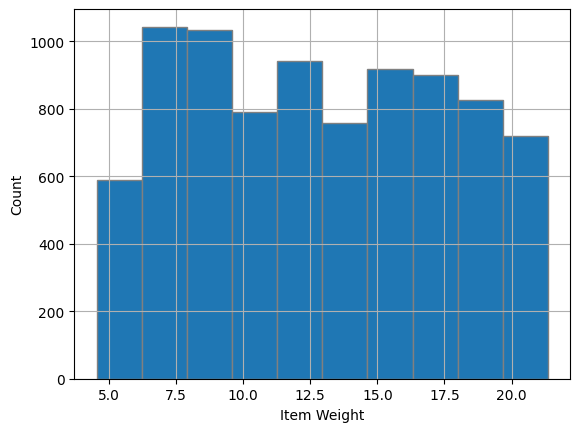

In [29]:
df['Item_Weight'].hist(edgecolor='grey')
plt.xlabel('Item Weight')
plt.ylabel('Count')
plt.show()

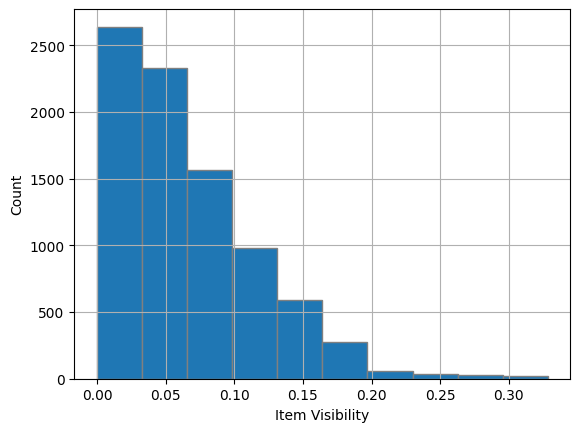

In [30]:
df['Item_Visibility'].hist(edgecolor='grey')
plt.xlabel('Item Visibility')
plt.ylabel('Count')
plt.show()

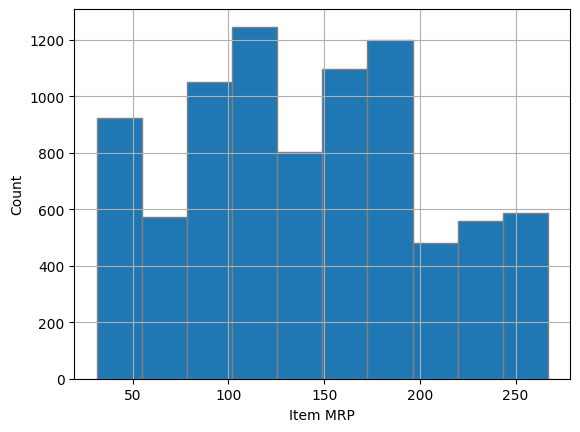

In [31]:
df['Item_MRP'].hist(edgecolor='grey')
plt.xlabel('Item MRP')
plt.ylabel('Count')
plt.show()

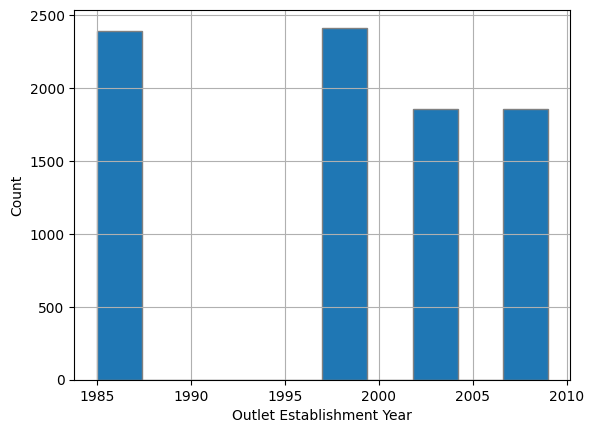

In [32]:
df['Outlet_Establishment_Year'].hist(edgecolor='grey')
plt.xlabel('Outlet Establishment Year')
plt.ylabel('Count')
plt.show()

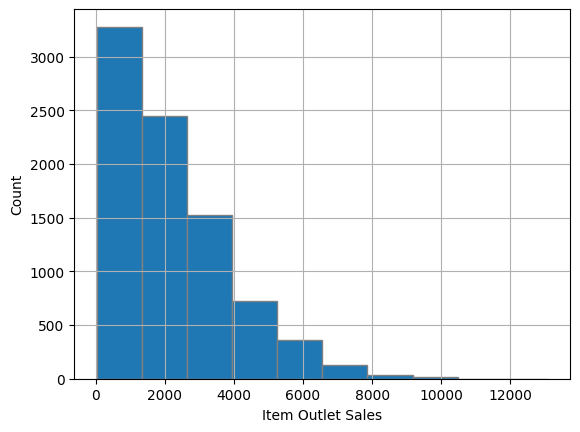

In [33]:
df['Item_Outlet_Sales'].hist(edgecolor='grey')
plt.xlabel('Item Outlet Sales')
plt.ylabel('Count')
plt.show()

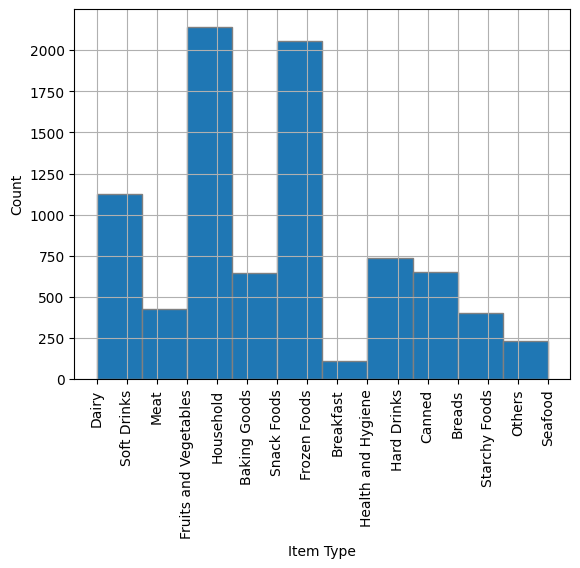

In [34]:
df['Item_Type'].hist(edgecolor='grey')
plt.xlabel('Item Type')
plt.xticks(rotation=90)
plt.ylabel('Count')
plt.show()

Item_Visibility e Item_Outlet_Sales siguen una distribución geométrica.

Los productos más vendidos son frutas y vegetales, junto con comida congelada. Los menos vendidos son productos de desayuno

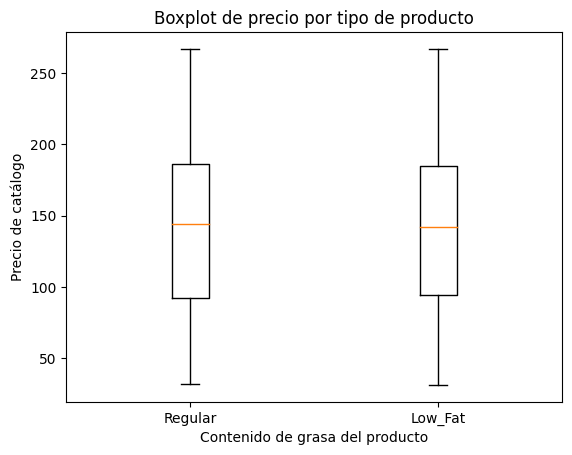

In [35]:
regular = df[df['Item_Fat_Content'] == 'Regular']['Item_MRP']
low_fat = df[df['Item_Fat_Content'] == 'Low Fat']['Item_MRP']

data = [regular, low_fat]

fig, ax = plt.subplots()

ax.boxplot(data)

ax.set_xticklabels(['Regular', 'Low_Fat'])
ax.set_xlabel('Contenido de grasa del producto')
ax.set_ylabel('Precio de catálogo')
ax.set_title('Boxplot de precio por tipo de producto')

plt.show()

Se puede apreciar que no existe mayor diferencia en los precios de los productos bajos en grasas con los productos regulares

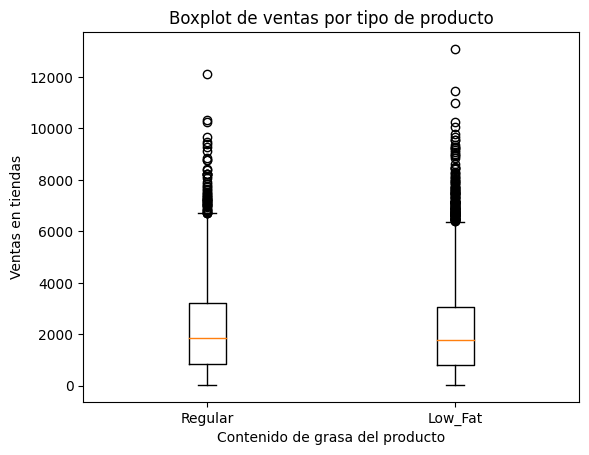

In [36]:
regular = df[df['Item_Fat_Content'] == 'Regular']['Item_Outlet_Sales']
low_fat = df[df['Item_Fat_Content'] == 'Low Fat']['Item_Outlet_Sales']

data = [regular, low_fat]

fig, ax = plt.subplots()

ax.boxplot(data)

ax.set_xticklabels(['Regular', 'Low_Fat'])
ax.set_xlabel('Contenido de grasa del producto')
ax.set_ylabel('Ventas en tiendas')
ax.set_title('Boxplot de ventas por tipo de producto')

plt.show()

Se aprecia que independiente del contenido de grasa del producto, las ventas son casi iguales en las tiendas

C:\Users\fabia\AppData\Local\Temp\ipykernel_8064\2816810641.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


<AxesSubplot: >

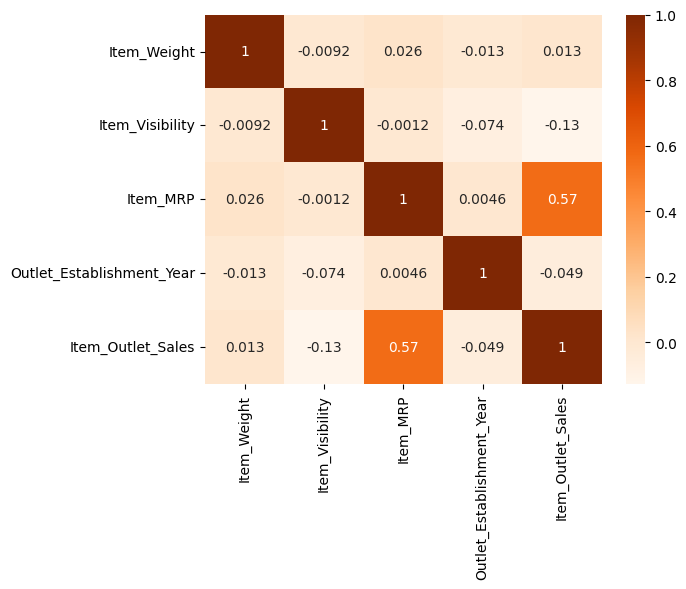

In [37]:
corr = df.corr()
sns.heatmap(corr,cmap='Oranges',annot=True)

Item_MRP e Item_Outlet_Sales presentan una correlación moderada. En cuanto a las otras variables, no se puede identificar ninguna relación.

In [38]:
grupo1 = df.groupby('Outlet_Type')['Item_Identifier'].count()
grupo1

Outlet_Type
Grocery Store        1082
Supermarket Type1    5577
Supermarket Type2     928
Supermarket Type3     932
Name: Item_Identifier, dtype: int64

In [39]:
print(grupo1.keys())
print(grupo1.values)

Index(['Grocery Store', 'Supermarket Type1', 'Supermarket Type2',
       'Supermarket Type3'],
      dtype='object', name='Outlet_Type')
[1082 5577  928  932]


C:\Users\fabia\AppData\Local\Temp\ipykernel_8064\2435165884.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


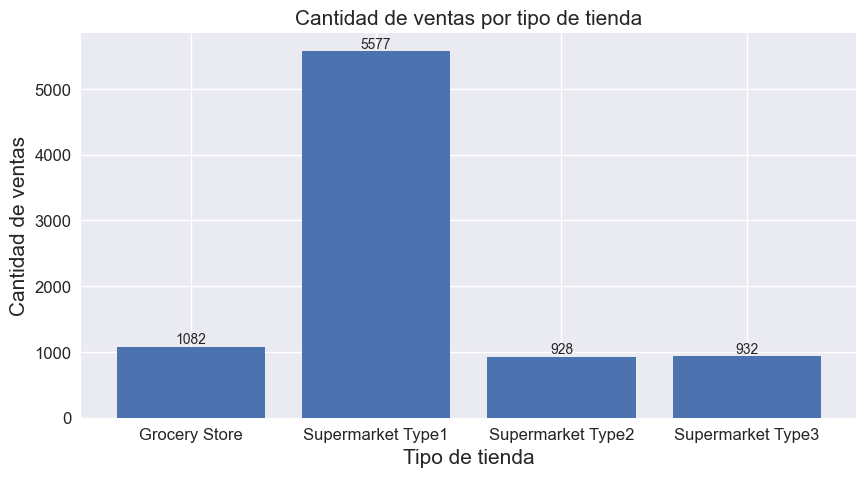

In [40]:
#El objetivo de esto es ayudar al minorista a comprender las propiedades de los productos y los puntos de venta que desempeñan un papel crucial en el aumento de las ventas.
fig = plt.figure(dpi=100,figsize=(10,5))
plt.style.use('seaborn')

plt.title('Cantidad de ventas por tipo de tienda',fontsize=15)
plt.xlabel('Tipo de tienda',fontsize=15)
plt.ylabel('Cantidad de ventas',fontsize=15)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.bar(grupo1.index,grupo1.values)
for i, v in enumerate(grupo1.values):
    plt.text(i, v, str(v), ha='center', va='bottom')

plt.show()

La tienda Supermarket Type1 es quien más vende, debido también a que es el tipo de tienda que tiene más representantes.

In [41]:
grupo_fat_type = df.groupby(['Item_Type','Item_Fat_Content'])['Item_Identifier'].count().reset_index()
grupo_fat_type

,Item_Type,Item_Fat_Content,Item_Identifier
0,Baking Goods,Low Fat,329
1,Baking Goods,Regular,318
2,Breads,Low Fat,140
3,Breads,Regular,111
4,Breakfast,Low Fat,41
5,Breakfast,Regular,69
6,Canned,Low Fat,341
7,Canned,Regular,308
8,Dairy,Low Fat,418
9,Dairy,Regular,263


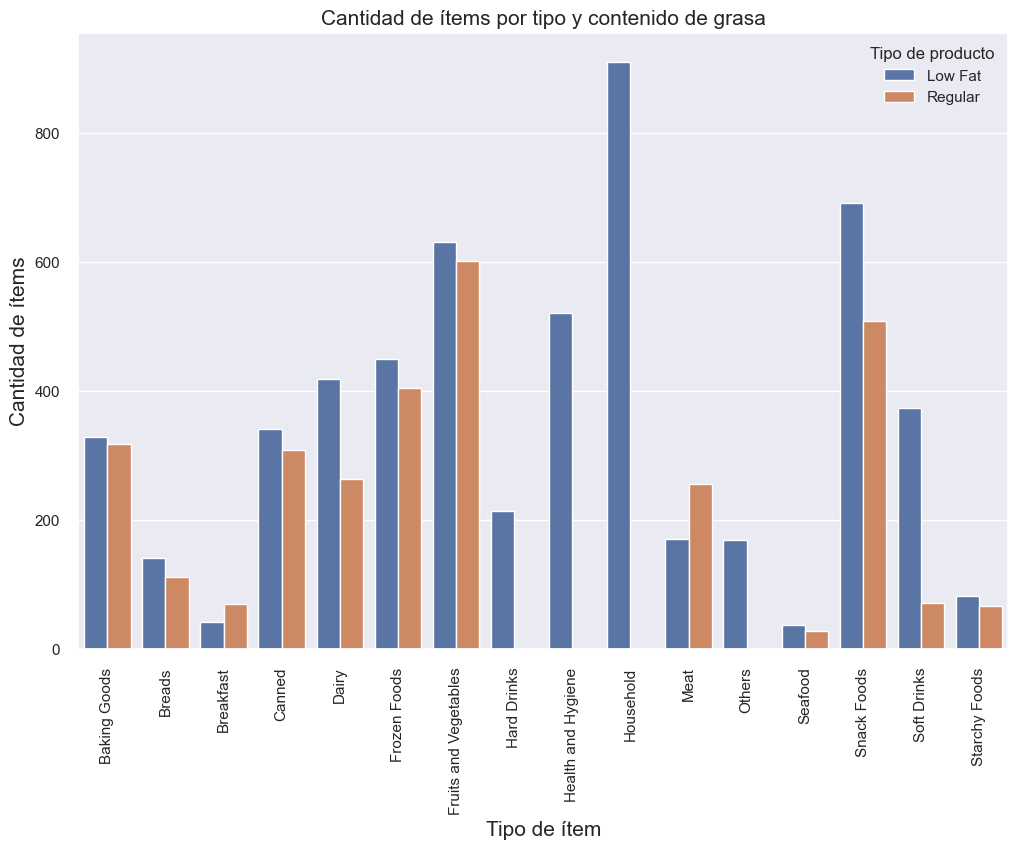

In [42]:
#Código extraido de ChatGPT
sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(12,8)})
sns.barplot(x='Item_Type', y='Item_Identifier', hue='Item_Fat_Content', data=grupo_fat_type)
plt.title('Cantidad de ítems por tipo y contenido de grasa',fontsize=15)
plt.xlabel('Tipo de ítem',fontsize=15)
plt.xticks(rotation=90)
plt.ylabel('Cantidad de ítems',fontsize=15)
plt.legend(title='Tipo de producto')
plt.show()

Podemos apreciar que en la mayoría de productos de los cuales se tiene datos en la categoría "Regular" y "Low Fat", a excepción de la carne y productos de desayuno, el público prefiere productos bajos en grasas

# Aprendizaje Automático
Utilizaremos el conjunto de datos original

In [43]:
df = pd.read_csv(filename)
df.head(10)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.930,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052
5,FDP36,10.395,Regular,0.000000,Baking Goods,51.4008,OUT018,2009,Medium,Tier 3,Supermarket Type2,556.6088
6,FDO10,13.650,Regular,0.012741,Snack Foods,57.6588,OUT013,1987,High,Tier 3,Supermarket Type1,343.5528
7,FDP10,NaN,Low Fat,0.127470,Snack Foods,107.7622,OUT027,1985,Medium,Tier 3,Supermarket Type3,4022.7636
8,FDH17,16.200,Regular,0.016687,Frozen Foods,96.9726,OUT045,2002,NaN,Tier 2,Supermarket Type1,1076.5986
9,FDU28,19.200,Regular,0.094450,Frozen Foods,187.8214,OUT017,2007,NaN,Tier 2,Supermarket Type1,4710.5350


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [45]:
X = df.drop(columns='Item_Outlet_Sales')
y = df['Item_Outlet_Sales']
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42)

In [46]:
cat_selector = make_column_selector(dtype_include='object')
num_selector = make_column_selector(dtype_include='number')

In [47]:
# Imputers
freq_imputer = SimpleImputer(strategy='most_frequent')
mean_imputer = SimpleImputer(strategy='mean')
# Scaler
scaler = StandardScaler()
# One-hot encoder
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

In [48]:
#Para valores numéricos
numeric_pipe = make_pipeline(mean_imputer, scaler)
numeric_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler())])

In [49]:
#Para valores categóricos
categorical_pipe = make_pipeline(freq_imputer, ohe)
categorical_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                ('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse=False))])

In [50]:
number_tuple = (numeric_pipe, num_selector)
category_tuple = (categorical_pipe, cat_selector)
# ColumnTransformer
preprocessor = make_column_transformer(number_tuple, category_tuple)
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000011E1FEDDE40>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000011E1FEDE860>)])

In [51]:
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000011E1FEDDE40>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x0000011E1FEDE860>)])

In [52]:
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [53]:
print(np.isnan(X_train_processed).sum().sum(), 'missing values in training data')
print(np.isnan(X_test_processed).sum().sum(), 'missing values in testing data')
print('\n')
print('All data in X_train_processed are', X_train_processed.dtype)
print('All data in X_test_processed are', X_test_processed.dtype)
print('\n')
print('shape of data is', X_train_processed.shape)
print('\n')
X_train_processed

0 missing values in training data
0 missing values in testing data


All data in X_train_processed are float64
All data in X_test_processed are float64


shape of data is (6392, 1595)




array([[ 0.81724868, -0.71277507,  1.82810922, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.5563395 , -1.29105225,  0.60336888, ...,  0.        ,
         1.        ,  0.        ],
       [-0.13151196,  1.81331864,  0.24454056, ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [ 1.11373638, -0.92052713,  1.52302674, ...,  1.        ,
         0.        ,  0.        ],
       [ 1.76600931, -0.2277552 , -0.38377708, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.81724868, -0.95867683, -0.73836105, ...,  1.        ,
         0.        ,  0.        ]])